In [1]:
# Import necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Login to wandb (if not already logged in)
wandb.login()

# Define the project and entity
project_name = "Negatives"
entity_name = "ntourne"

# Initialize the wandb API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{entity_name}/{project_name}")

wandb: Currently logged in as: ntourne to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Initialize a list to store results
results = []

# Iterate through runs and extract metrics
for run in runs:
    # Get the summary metrics, config, and name of the run
    summary = run.summary._json_dict
    config = run.config
    name = run.name
    
    # Combine the data into a single dictionary
    run_data = {
        "run_name": name,
        "TF": config.get("TF"),
        "celltype": config.get("celltype"),
        "neg_mode": config.get("neg_mode"),
        "cross_val_set": config.get("cross_val_set"),
        "group_name": config.get("group_name"),
        "AUROC": summary.get("best_AUROC"),
        "AUROC_HQ": summary.get("best_AUROC_HQ"),
        "Accuracy": summary.get("best_Accuracy"),
        "Accuracy_HQ": summary.get("best_Accuracy_HQ"),
        "val_loss": summary.get("val_loss"),
    }
    results.append(run_data)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

In [3]:
results_df = results_df[results_df['group_name'] == "prelim_run_1"] # Only get prelim_run_1

In [4]:
# Filter out entries where AUROC_HQ == 0 -> probably an issue with the cross val split 
filtered_out_count = results_df[(results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna())].shape[0]

# Filter the DataFrame to exclude these entries
results_df = results_df[~((results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna()))]

# Print the count of filtered-out entries
print(f"Number of entries where AUROC_HQ == 0: {filtered_out_count}")

Number of entries where AUROC_HQ == 0: 24


In [5]:
results_df["TF"].value_counts()

TF
YY1_(SC-281)         29
CTCF                 24
CREB1_(SC-240)       24
Max                  24
TCF12                24
FOSL2                24
ELF1_(SC-631)        24
BHLHE40              24
ATF3                 24
USF-1                24
SIX5                 24
ETS1                 16
ZBTB33               16
FOXA1_(SC-101058)    16
Name: count, dtype: int64

In [6]:
# Filter for rows where TF contains 'YY1_'
yy1_df = results_df[results_df['TF']=="YY1_(SC-281)"]

# Group by 'neg_mode' and 'cross_val_set' to check for duplicates
grouped = yy1_df.groupby(['neg_mode', 'cross_val_set']).size()


print(grouped)

neg_mode         cross_val_set
dinucl_sampled   0.0              2
                 1.0              1
                 2.0              1
                 3.0              2
                 4.0              2
                 5.0              2
dinucl_shuffled  0.0              2
                 1.0              1
                 2.0              1
                 3.0              1
                 4.0              1
                 5.0              1
neighbors        0.0              1
                 1.0              1
                 2.0              1
                 3.0              1
                 4.0              1
                 5.0              1
shuffled         0.0              1
                 1.0              1
                 2.0              1
                 3.0              1
                 4.0              1
                 5.0              1
dtype: int64


In [ ]:
#! THIS IS HOW IT SHOULD BE
# Filter for rows where TF contains 'YY1_'
CTCF_df = results_df[results_df['TF']=="CTCF"]

# Group by 'neg_mode' and 'cross_val_set' to check for duplicates
grouped = CTCF_df.groupby(['neg_mode', 'cross_val_set']).size()


print(grouped)

neg_mode         cross_val_set
dinucl_sampled   0.0              1
                 1.0              1
                 2.0              1
                 3.0              1
                 4.0              1
                 5.0              1
dinucl_shuffled  0.0              1
                 1.0              1
                 2.0              1
                 3.0              1
                 4.0              1
                 5.0              1
neighbors        0.0              1
                 1.0              1
                 2.0              1
                 3.0              1
                 4.0              1
                 5.0              1
shuffled         0.0              1
                 1.0              1
                 2.0              1
                 3.0              1
                 4.0              1
                 5.0              1
dtype: int64


In [ ]:
results_df["TF"].value_counts()

TF
YY1_(SC-281)         29
CTCF                 24
CREB1_(SC-240)       24
Max                  24
TCF12                24
FOSL2                24
ELF1_(SC-631)        24
BHLHE40              24
ATF3                 24
USF-1                24
SIX5                 24
ETS1                 16
ZBTB33               16
FOXA1_(SC-101058)    16
Name: count, dtype: int64

In [ ]:
# Filter out TFs with less than 24 samples
results_df = results_df.groupby('TF').filter(lambda x: len(x) >= 24)

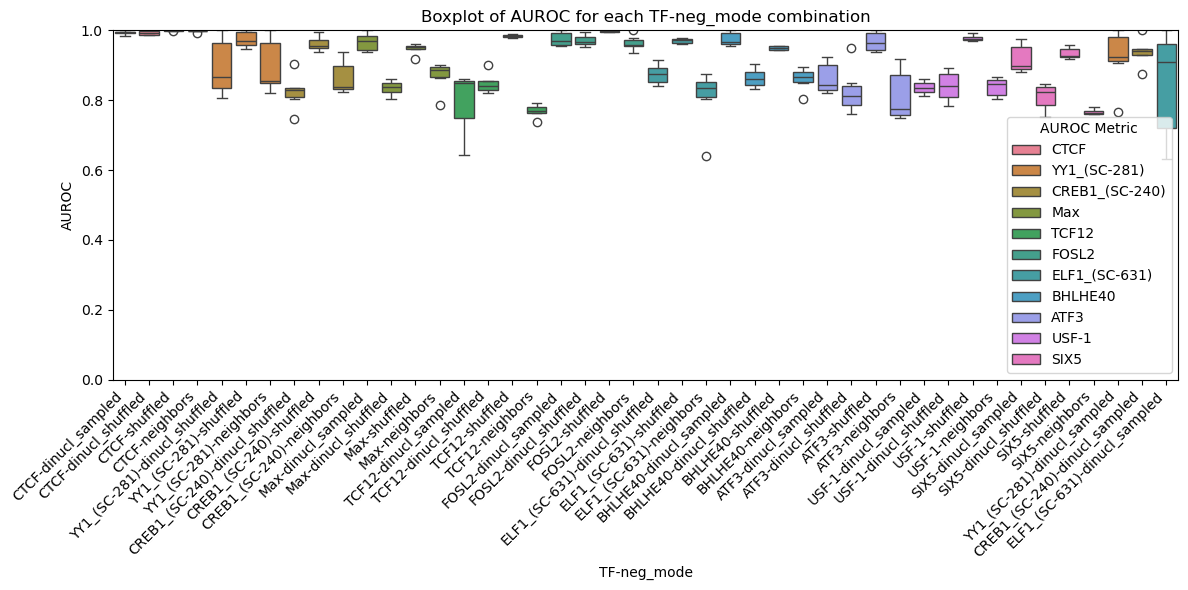

In [ ]:
import seaborn as sns
# Create a new column combining TF and neg_mode
results_df['TF-neg_mode'] = results_df['TF'] + '-' + results_df['neg_mode']
results_df.sort_values(by=['TF', 'TF-neg_mode'])

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='TF-neg_mode', y='AUROC', hue="TF")
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of AUROC for each TF-neg_mode combination')
plt.legend(title='AUROC Metric', loc='lower right')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

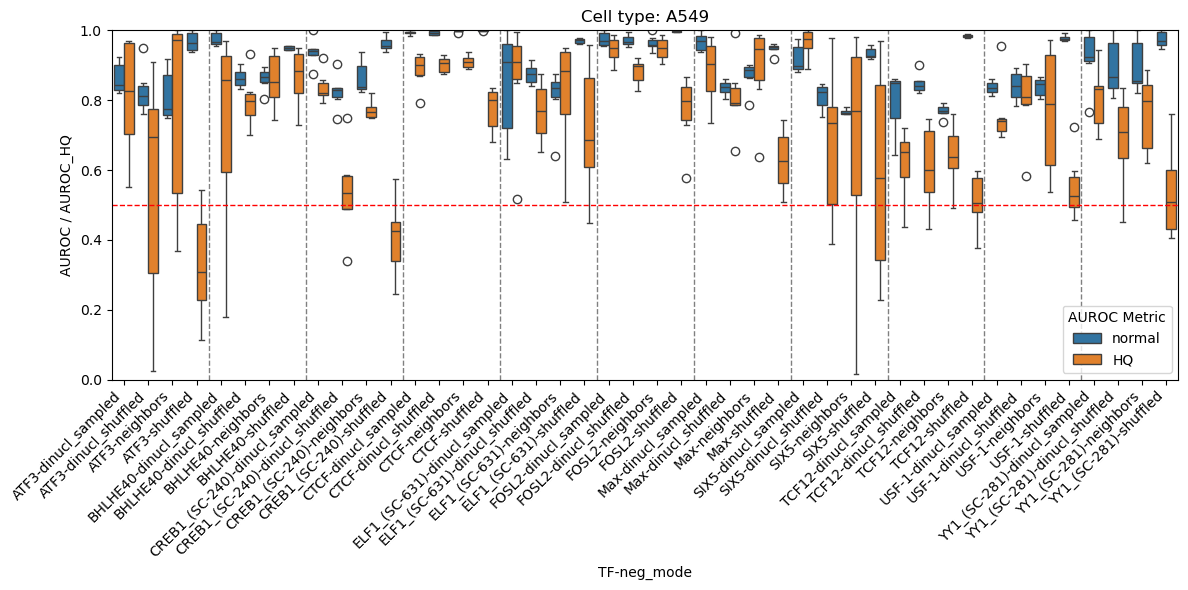

In [ ]:
# Create the boxplot for AUROC
plt.figure(figsize=(12, 6))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF', 'TF-neg_mode']),
    id_vars=['TF-neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})


# Create the boxplot
sns.boxplot(data=melted_df, x='TF-neg_mode', y='AUROC_value', hue='auroc_metric')

# Add vertical lines between groups of the same TF
unique_tf_neg_modes = results_df.sort_values(by=['TF', 'TF-neg_mode'])['TF-neg_mode'].unique()
tf_groups = [tf.split('-')[0] for tf in unique_tf_neg_modes]
group_changes = [i for i in range(1, len(tf_groups)) if tf_groups[i] != tf_groups[i - 1]]

for change in group_changes:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: A549')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
results_df["AUROC_delta"] = results_df["AUROC"] - results_df["AUROC_HQ"]

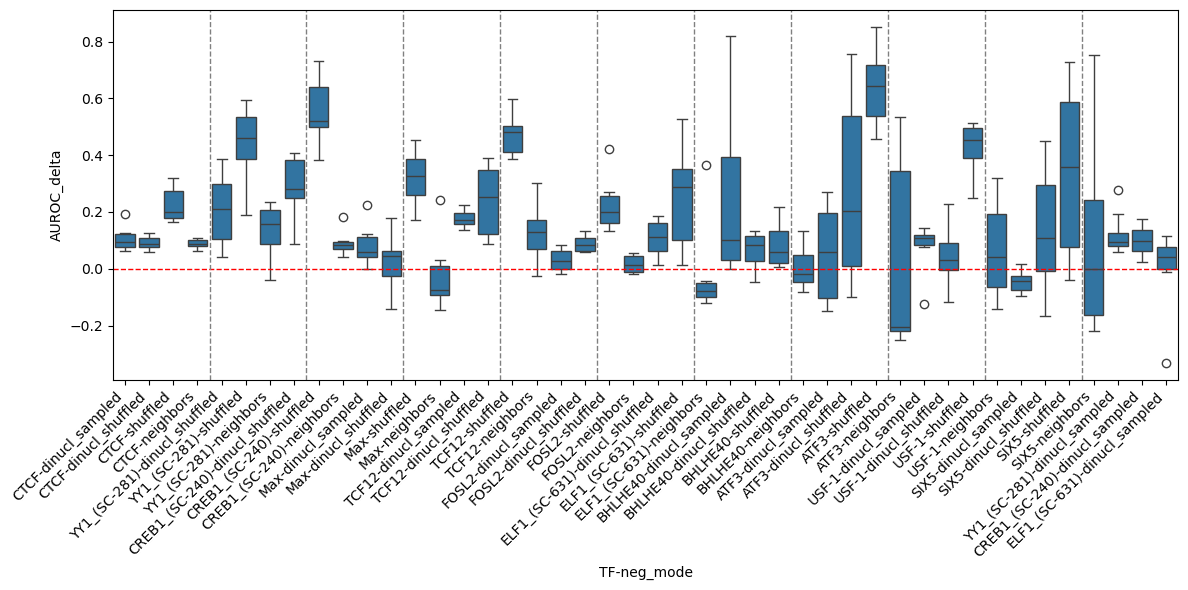

In [ ]:
plt.figure(figsize=(12, 6))
# Create the boxplot
sns.boxplot(data=results_df, x='TF-neg_mode', y='AUROC_delta')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
# Add vertical lines between groups of the same TF
unique_tf_neg_modes = results_df.sort_values(by=['TF', 'TF-neg_mode'])['TF-neg_mode'].unique()
tf_groups = [tf.split('-')[0] for tf in unique_tf_neg_modes]
group_changes = [i for i in range(1, len(tf_groups)) if tf_groups[i] != tf_groups[i - 1]]

for change in group_changes:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)
# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

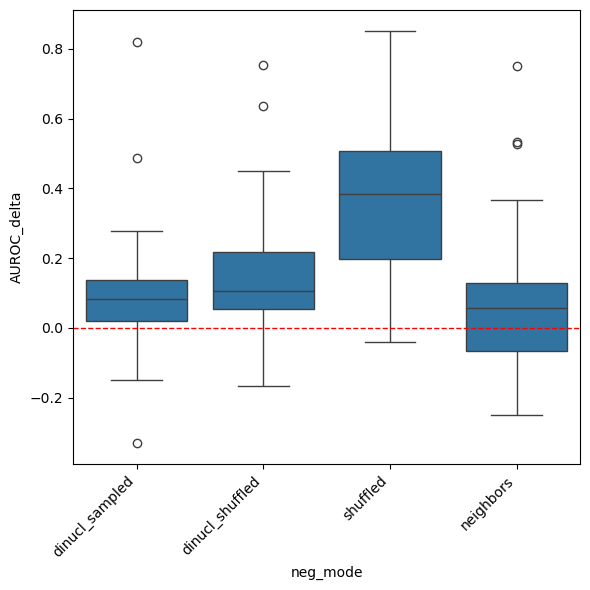

In [ ]:
plt.figure(figsize=(6, 6))
# Create the boxplot
sns.boxplot(data=results_df, x='neg_mode', y='AUROC_delta')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

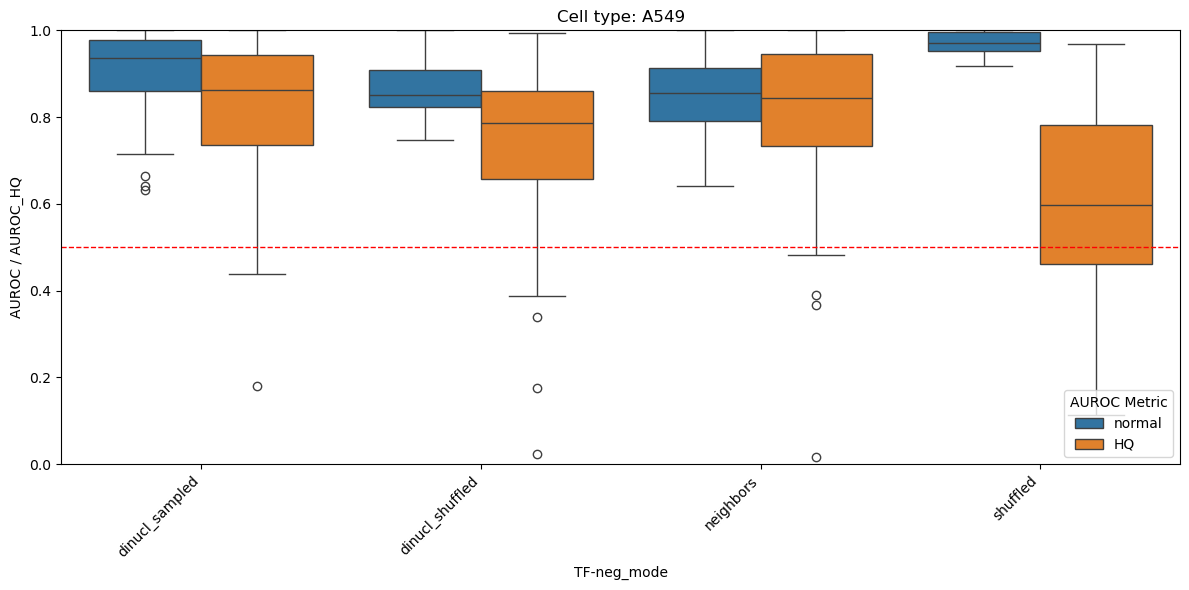

In [ ]:
# Create the boxplot for AUROC
plt.figure(figsize=(12, 6))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF-neg_mode']),
    id_vars=['neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})


# Create the boxplot
sns.boxplot(data=melted_df, x='neg_mode', y='AUROC_value', hue='auroc_metric')



# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: A549')
plt.xlabel('TF-neg_mode')

plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
